In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip
import copy

import import_ipynb
from My_Functions import null_cols, rmse

importing Jupyter notebook from My_Functions.ipynb


In [2]:
acc_TC = pd.read_csv("acc_TC.csv.gz",
                     compression='gzip',
                     header=0,
                     sep=',',
                     quotechar='"')

target_1_TC = pd.read_csv("target_2_train_feateng_dwnsmpl.csv.gz",
                          compression='gzip',
                          header=0,
                          sep=',',
                          quotechar='"')

In [3]:
acc_TC_nograde = acc_TC.drop(['grade', 'sub_grade'], axis=1)

In [4]:
state=0


# original:
xtrain_ds, xtest_ds, ytrain_ds, ytest_ds = ms.train_test_split(acc_TC,
                                                               target_1_TC,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_ds = ytrain_ds.values.flatten()


# no grade or subgrade:
xtrain_no, xtest_no, ytrain_no, ytest_no = ms.train_test_split(acc_TC_nograde,
                                                               target_1_TC,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_no = ytrain_no.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Theodore's Reduced Dataset

In [5]:
xgb_clsfr_ds = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_ds = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_ds = ms.GridSearchCV(xgb_clsfr_ds, gparam_xgb_ds, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_ds.fit(xtrain_ds, ytrain_ds)

# setting up dataframe for results
train_scores.append(gs_xgb_ds.best_estimator_.score(xtrain_ds, ytrain_ds))
test_scores.append(gs_xgb_ds.best_estimator_.score(xtest_ds, ytest_ds))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_ds, ytrain_ds, xtrain_ds))
test_rmse.append(rmse(gs_xgb_ds, ytest_ds, xtest_ds))

# add the best parameters to the df
best_par_list.append(gs_xgb_ds.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_ds, gs_xgb_ds.predict(xtrain_ds)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_ds, gs_xgb_ds.predict(xtest_ds)))

res_df

Wall time: 8.34 s


confusion matrix for train set
[[71446 36264]
 [31755 76023]]


confusion matrix for test set
[[17111  9859]
 [ 8736 18166]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.684349,0.65483,0.561828,0.587512,-0.025683,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [6]:
sorted_importance_ds = sorted(zip(xtrain_ds.columns,
                               gs_xgb_ds.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance_ds

[('grade', 0.59594995),
 ('sub_grade', 0.1449023),
 ('term', 0.087689124),
 ('home_ownership', 0.027244605),
 ('loan_amnt', 0.015105736),
 ('verification_status', 0.012771034),
 ('emp_length', 0.012604721),
 ('dti', 0.011728723),
 ('fico_score', 0.011535604),
 ('int_rate', 0.011069286),
 ('annual_inc', 0.010170974),
 ('funded_amnt', 0.009323393),
 ('duration_of_credit_months', 0.008554774),
 ('installment', 0.008463909),
 ('sec_app_fico_score', 0.007838931),
 ('dti_joint', 0.007512506),
 ('annual_inc_joint', 0.006267786),
 ('sec_app_duration_of_credit_months', 0.005500937),
 ('verification_status_joint', 0.0048470106),
 ('application_type', 0.0009187464)]

In [7]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

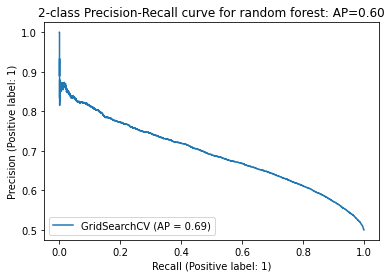

In [8]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_ds, xtest_ds, ytest_ds)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [9]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
recall_score = metrics.recall_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
precision_score = metrics.precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.66
recall score: 0.68
precision score: 0.65


In [10]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6548557299407809

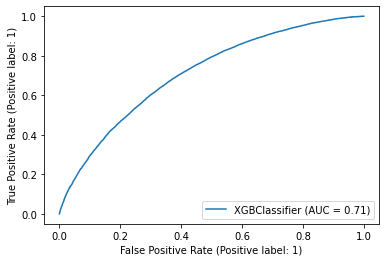

In [11]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_ds.best_estimator_, xtest_ds, ytest_ds) 

In [12]:
filtered_sorted_importance_ds = [x for x in sorted_importance_ds if x[1]>0.0035]
filtered_sorted_importance_ds

[('grade', 0.59594995),
 ('sub_grade', 0.1449023),
 ('term', 0.087689124),
 ('home_ownership', 0.027244605),
 ('loan_amnt', 0.015105736),
 ('verification_status', 0.012771034),
 ('emp_length', 0.012604721),
 ('dti', 0.011728723),
 ('fico_score', 0.011535604),
 ('int_rate', 0.011069286),
 ('annual_inc', 0.010170974),
 ('funded_amnt', 0.009323393),
 ('duration_of_credit_months', 0.008554774),
 ('installment', 0.008463909),
 ('sec_app_fico_score', 0.007838931),
 ('dti_joint', 0.007512506),
 ('annual_inc_joint', 0.006267786),
 ('sec_app_duration_of_credit_months', 0.005500937),
 ('verification_status_joint', 0.0048470106)]

In [13]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance_ds:
    filter_important.append(tup[0])

filter_important

['grade',
 'sub_grade',
 'term',
 'home_ownership',
 'loan_amnt',
 'verification_status',
 'emp_length',
 'dti',
 'fico_score',
 'int_rate',
 'annual_inc',
 'funded_amnt',
 'duration_of_credit_months',
 'installment',
 'sec_app_fico_score',
 'dti_joint',
 'annual_inc_joint',
 'sec_app_duration_of_credit_months',
 'verification_status_joint']

# No Grade or Subgrade

In [14]:
xgb_clsfr_no = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_no = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_no = ms.GridSearchCV(xgb_clsfr_no, gparam_xgb_no, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_no.fit(xtrain_no, ytrain_no)

# setting up dataframe for results
train_scores.append(gs_xgb_no.best_estimator_.score(xtrain_no, ytrain_no))
test_scores.append(gs_xgb_no.best_estimator_.score(xtest_no, ytest_no))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_no, ytrain_no, xtrain_no))
test_rmse.append(rmse(gs_xgb_no, ytest_no, xtest_no))

# add the best parameters to the df
best_par_list.append(gs_xgb_no.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_no, gs_xgb_no.predict(xtrain_no)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_no, gs_xgb_no.predict(xtest_no)))

res_df

Wall time: 7.5 s


confusion matrix for train set
[[71257 36453]
 [32478 75300]]


confusion matrix for test set
[[17075  9895]
 [ 8893 18009]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.680117,0.651247,0.565582,0.590553,-0.024971,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [15]:
sorted_importance_no = sorted(zip(xtrain_no.columns,
                               gs_xgb_no.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance_no

[('int_rate', 0.29059044),
 ('term', 0.2521744),
 ('home_ownership', 0.07468774),
 ('verification_status', 0.040164072),
 ('loan_amnt', 0.035998587),
 ('emp_length', 0.035576593),
 ('fico_score', 0.03462055),
 ('dti', 0.033869818),
 ('annual_inc', 0.027997812),
 ('funded_amnt', 0.025878254),
 ('installment', 0.02440904),
 ('sec_app_fico_score', 0.023788238),
 ('duration_of_credit_months', 0.023280168),
 ('verification_status_joint', 0.02024309),
 ('dti_joint', 0.017553203),
 ('annual_inc_joint', 0.016324483),
 ('sec_app_duration_of_credit_months', 0.0162826),
 ('application_type', 0.0065608653)]

In [16]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_no, gs_xgb_no.predict(xtest_no))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

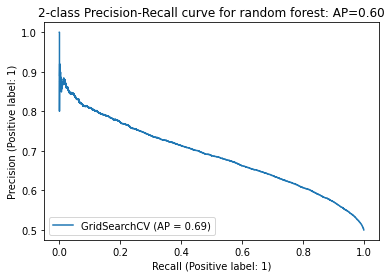

In [17]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_no, xtest_no, ytest_no)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [18]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_no, gs_xgb_no.predict(xtest_no))
recall_score = metrics.recall_score(ytest_no, gs_xgb_no.predict(xtest_no))
precision_score = metrics.precision_score(ytest_no, gs_xgb_no.predict(xtest_no))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.66
recall score: 0.67
precision score: 0.65


In [19]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_no, gs_xgb_no.predict(xtest_no))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6512703230476034

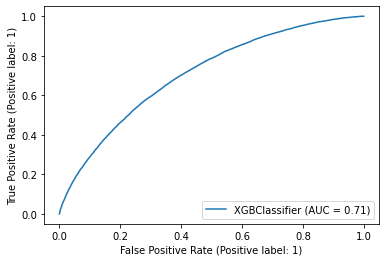

In [20]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_no.best_estimator_, xtest_no, ytest_no) 

In [21]:
filtered_sorted_importance_no = [x for x in sorted_importance_no if x[1]>0.0035]
filtered_sorted_importance_no

[('int_rate', 0.29059044),
 ('term', 0.2521744),
 ('home_ownership', 0.07468774),
 ('verification_status', 0.040164072),
 ('loan_amnt', 0.035998587),
 ('emp_length', 0.035576593),
 ('fico_score', 0.03462055),
 ('dti', 0.033869818),
 ('annual_inc', 0.027997812),
 ('funded_amnt', 0.025878254),
 ('installment', 0.02440904),
 ('sec_app_fico_score', 0.023788238),
 ('duration_of_credit_months', 0.023280168),
 ('verification_status_joint', 0.02024309),
 ('dti_joint', 0.017553203),
 ('annual_inc_joint', 0.016324483),
 ('sec_app_duration_of_credit_months', 0.0162826),
 ('application_type', 0.0065608653)]

In [22]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance_no:
    filter_important.append(tup[0])

filter_important

['int_rate',
 'term',
 'home_ownership',
 'verification_status',
 'loan_amnt',
 'emp_length',
 'fico_score',
 'dti',
 'annual_inc',
 'funded_amnt',
 'installment',
 'sec_app_fico_score',
 'duration_of_credit_months',
 'verification_status_joint',
 'dti_joint',
 'annual_inc_joint',
 'sec_app_duration_of_credit_months',
 'application_type']

# Very Reduced Data

In [23]:
acc_vred = pd.read_csv("acc_vred.csv.gz",
                       compression='gzip',
                       header=0,
                       sep=',',
                       quotechar='"')


In [24]:
# dno grade or subgrade:
xtrain_vred, xtest_vred, ytrain_vred, ytest_vred = ms.train_test_split(acc_vred,
                                                               target_1_TC,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_vred = ytrain_vred.values.flatten()

In [25]:
xgb_clsfr_vred = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_vred = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_vred = ms.GridSearchCV(xgb_clsfr_vred, gparam_xgb_vred, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_vred.fit(xtrain_vred, ytrain_vred)

# setting up dataframe for results
train_scores.append(gs_xgb_vred.best_estimator_.score(xtrain_vred, ytrain_vred))
test_scores.append(gs_xgb_vred.best_estimator_.score(xtest_vred, ytest_vred))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_vred, ytrain_vred, xtrain_vred))
test_rmse.append(rmse(gs_xgb_vred, ytest_vred, xtest_vred))

# add the best parameters to the df
best_par_list.append(gs_xgb_vred.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_vred, gs_xgb_vred.predict(xtrain_vred)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_vred, gs_xgb_vred.predict(xtest_vred)))

res_df

Wall time: 6.86 s


confusion matrix for train set
[[70634 37076]
 [33683 74095]]


confusion matrix for test set
[[17138  9832]
 [ 9051 17851]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.671634,0.649484,0.573033,0.592044,-0.019011,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [26]:
sorted_importance_vred = sorted(zip(xtrain_vred.columns,
                               gs_xgb_vred.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance_vred

[('int_rate', 0.3617245),
 ('term', 0.35167125),
 ('home_ownership', 0.09682313),
 ('all_util', 0.053307217),
 ('annual_inc', 0.04791027),
 ('fico_score', 0.045162834),
 ('loan_amnt', 0.043400776)]

In [27]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_vred, gs_xgb_vred.predict(xtest_vred))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

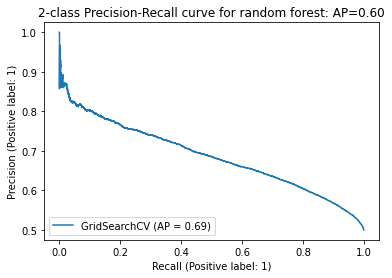

In [28]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_vred, xtest_vred, ytest_vred)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [29]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_vred, gs_xgb_vred.predict(xtest_vred))
recall_score = metrics.recall_score(ytest_vred, gs_xgb_vred.predict(xtest_vred))
precision_score = metrics.precision_score(ytest_vred, gs_xgb_vred.predict(xtest_vred))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.65
recall score: 0.66
precision score: 0.64


In [30]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_vred, gs_xgb_vred.predict(xtest_vred))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6495017028119503

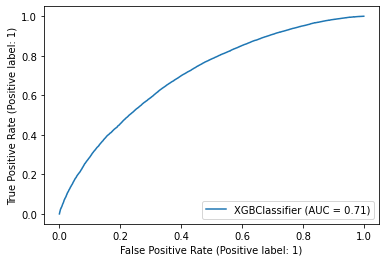

In [31]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_vred.best_estimator_, xtest_vred, ytest_vred) 

In [32]:
filtered_sorted_importance_vred = [x for x in sorted_importance_vred if x[1]>0.0035]
filtered_sorted_importance_vred

[('int_rate', 0.3617245),
 ('term', 0.35167125),
 ('home_ownership', 0.09682313),
 ('all_util', 0.053307217),
 ('annual_inc', 0.04791027),
 ('fico_score', 0.045162834),
 ('loan_amnt', 0.043400776)]

In [33]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance_vred:
    filter_important.append(tup[0])

filter_important

['int_rate',
 'term',
 'home_ownership',
 'all_util',
 'annual_inc',
 'fico_score',
 'loan_amnt']